# Dynamic Systems & Bistable Perception

## Introduction

In the next section we are going to explore some **dynamics** of running a model, including how information flows and is modified over time.  We will be building up to a simple model of bistable perception for a figure that people can readily interpret in two different ways.

![necker cube](https://raw.githubusercontent.com/younesStrittmatter/502B/refs/heads/main/book/content/chapter_1/assets/necker-cube.png)

Two classic examples of bistable figures are the "Duck Rabbit" seen as either of two animals (but not usually both simultaneously), and the Necker Cube, where the face of the cube that you initially see as closest to you can alternatively be interpreted as farthest away from you.  We are going to work toward a Model of settling on one interpretation of the Necker Cube, after first exploring some simple dynamic models.

## Code Examples

### Installation & Setup

In [ ]:
%%capture
!pip install psyneulink

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import psyneulink as pnl

### Dynamics 1: Attractor State

The following code creates a composition with two mechanisms that are mutually connected by weights of -1. The output of one mechanism is multiplied by -1 and given as the input to the next mechanism, in a repeating cycle. We can specify initial input values for each mechanism and watch it evolve over time.  

This particular mechanism will evolve toward stable values of 1 and -1. The values 1 and -1 are determined by the difference between the initial inputs. If the inputs are X and Y, this system will always evolve to $+/-abs[X-Y]/4$ (plus & minus the absolute value of the difference between the two inputs, divided by 4).  Whichever mechanism receives the larger initial input evolves to the positive value, while the smaller initial input evolves to the negative value.     

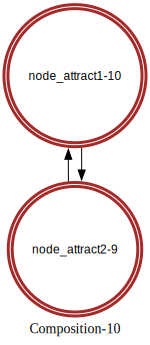

In [28]:
# Create a PsyNeuLink Composition
comp_attract = pnl.Composition()

# Create the first Transfer Mechanism (node)
node_attract1 = pnl.TransferMechanism(
    name='node_attract1',  # Name of the mechanism for identification in graphs and outputs.
    function=pnl.Linear(slope=1, intercept=0),  # Linear function with a slope of 1 and no intercept.
    integrator_mode=True,  # Enables integration of inputs over time (temporal smoothing).
    integration_rate=.5,  # Smoothing factor for integration: balance between current and previous input.
    default_variable=np.zeros((1,)),  # Default input format: a single scalar (vector of size 1).
)

# Create the second Transfer Mechanism (node)
node_attract2 = pnl.TransferMechanism(
    name='node_attract2',
    function=pnl.Linear(slope=1, intercept=0),  # Linear transfer function (identity mapping here).
    integrator_mode=True,  # Temporal smoothing enabled.
    integration_rate=.5,  # Same integration rate as the first node.
    default_variable=np.zeros((1,)),  # Default input format.
)

# Explanation of integration:
# With integrator_mode=True, the current activation is calculated as:
# (1 - integration_rate) * previous_value + integration_rate * current_input
# The mechanism's function is applied to this smoothed value.

# Define the connection weight from node 1 to node 2
connect_a1_a2 = ([-1])  # Weight matrix for mapping from node_attract1 to node_attract2.

# Define the connection weight from node 2 to node 1
connect_a2_a1 = ([-1])  # Weight matrix for mapping from node_attract2 to node_attract1.

# Create a MappingProjection from node_attract1 to node_attract2
weights_a1_a2 = pnl.MappingProjection(
    name='connect_a1_a2',  # Name of the projection for identification.
    matrix=connect_a1_a2,  # Weight matrix for the connection.
)

# Create a MappingProjection from node_attract2 to node_attract1
weights_a2_a1 = pnl.MappingProjection(
    name='connect_a2_a1',  # Name of the projection for identification.
    matrix=connect_a2_a1,  # Weight matrix for the connection.
)

# Add the nodes and projections to the composition as a circular pathway
# This defines a loop where the output of each node influences the other
comp_attract.add_linear_processing_pathway(
    pathway=(node_attract1, weights_a1_a2, node_attract2, weights_a2_a1, node_attract1)
)

# Enable detailed reporting of output for both nodes
node_attract1.reportOutputPref = True  # Output values will be reported during execution.
node_attract2.reportOutputPref = True

# Define inputs for each node over multiple trials
# The inputs will influence the activation and learning behavior of the system
input_a1 = 2  # Initial input to node_attract1.
input_a2 = 6  # Initial input to node_attract2.

input_dict = {
    node_attract1: [input_a1] + [0] * 9,  # Input sequence for node_attract1.
    node_attract2: [input_a2] + [0] * 9   # Input sequence for node_attract2.
}

# Execute the composition for a specified number of trials
comp_attract.run(
    inputs=input_dict,  # Provide the input sequences.
    num_trials=10  # Number of trials to run.
)

# Visualize the graph of the composition
comp_attract.show_graph(output_fmt='jupyter')  # This generates a graph showing the structure of the composition.

We can plot the results over successive time steps to get a clearer sense of how the system evolves over time.  Compare the plot below to your understanding of how the system evolves.

(10, 2)
[[ 1.  3.]
 [-1.  1.]
 [-1.  1.]
 [-1.  1.]
 [-1.  1.]
 [-1.  1.]
 [-1.  1.]
 [-1.  1.]
 [-1.  1.]
 [-1.  1.]]


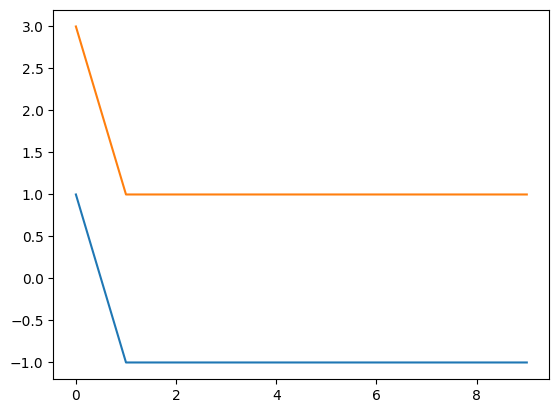

In [29]:
print(np.shape(np.squeeze(comp_attract.results)))
print(np.squeeze(comp_attract.results))
plt.plot(np.squeeze(comp_attract.results))

How did the system evolve over time?

To get a better, we can calculate the activations in each step by hand:

Remember that the activation of each node is calculated as:

$$
act_{1}(t) &= (1 - integration\_rate) * act_{1}(t-1) + integration\_rate * input_{1} \\
&= (1 - integration\_rate) * act_{1}(t-1) + integration\_rate * (input_{i, external} - act_{2}(t-1))
$$

$$
act_{1}(t) &= (1 - integration\_rate) * act_{1}(t-1) + integration\_rate * input_{1} \\
&= (1 - integration\_rate) * act_{1}(t-1) + integration\_rate * (input_{i, external} - act_{2}(t-1))
$$


##### Step 1

$$
act_{1}(1) &= (1 - integration\_rate) * act_{1}(0) + integration\_rate * (input_{i, external} - act_{2}(0)) \\
&= (1 - 0.5) * 0 + 0.5 * (2 - 0) \\
&= 1
$$

$$
act_{2}(1) &= (1 - integration\_rate) * act_{2}(0) + integration\_rate * (input_{i, external} - act_{1}(0)) \\
&= (1 - 0.5) * 0 + 0.5 * (6 - 0) \\
&= 3
$$

##### Step 2

$$
act_{1}(2) &= (1 - integration\_rate) * act_{1}(1) + integration\_rate * (input_{i, external} - act_{2}(1)) \\
&= (1 - 0.5) * 1 + 0.5 * (0 - 3) \\
&= -1
$$

$$
act_{2}(2) &= (1 - integration\_rate) * act_{2}(1) + integration\_rate * (input_{i, external} - act_{1}(1)) \\
&= (1 - 0.5) * 3 + 0.5 * (0 - 1) \\
&= 1
$$

##### Step 3

$$
act_{1}(3) &= (1 - integration\_rate) * act_{1}(2) + integration\_rate * (input_{i, external} - act_{2}(2)) \\
&= (1 - 0.5) * -1 + 0.5 * (0 - 1) \\
&= -1
$$

$$
act_{2}(2) &= (1 - integration\_rate) * act_{2}(1) + integration\_rate * (input_{i, external} - act_{1}(1)) \\
&= (1 - 0.5) * 1 + 0.5 * (0 - (-1)) \\
&= 1
$$

So the system has stabilized at $act_{1} = -1$ and $act_{2} = 1$.


Try to predict what happens if we change the input values of `node_attract1` and `node_attract2`.

In the previous cell, we executed the system 10 times (`num_trials = 10`), with initial input values specified as `input_a1 = 6` and `input_a2 = 2`, and all subsequent input values set equal to `0` in the input_dict. What happens if you set all the subsequent input values to `1` instead of `0`?

(10, 2)
[[ 1.   3. ]
 [-0.5  1.5]
 [-0.5  1.5]
 [-0.5  1.5]
 [-0.5  1.5]
 [-0.5  1.5]
 [-0.5  1.5]
 [-0.5  1.5]
 [-0.5  1.5]
 [-0.5  1.5]]


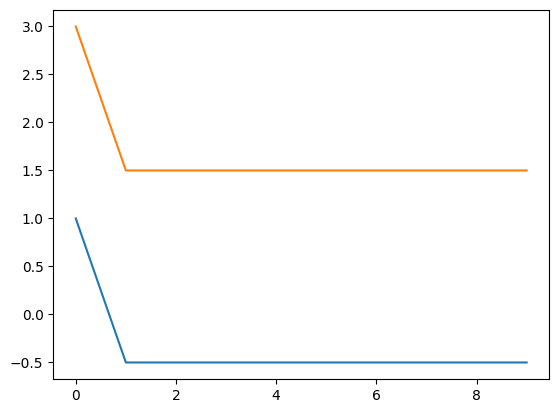

In [37]:
# Reset the composition ensuring that the results are cleared.
comp_attract.reset(clear_results=True)

input_dict = {
    node_attract1: [input_a1] + [1] * 9,  # Input sequence for node_attract1.
    node_attract2: [input_a2] + [1] * 9,  # Input sequence for node_attract2.
}

comp_attract.run(
    inputs=input_dict,
    num_trials=10
)

print(np.shape(np.squeeze(comp_attract.results)))
print(np.squeeze(comp_attract.results))
plt.plot(np.squeeze(comp_attract.results))

### Exercise 1

Explain the behavior of the system when the subsequent input values are set to `1` instead of `0`.

<details><summary><b>Solution</b></summary>

When the subsequent input values are set to `1` instead of `0` for both attractors, the system will evolve to a stable state where the output of `node_attract1` is `-0.5` and the output of `node_attract2` is `1.5`. With a constant input of `1` for both nodes, the stable state shifts `integration_rate` * `constant_input`. The relative difference between the two nodes remains the same, but the absolute values of the outputs are shifted by the constant input value.

</details>


Try to predict what happens if we change the functions in the `TransferMechanisms` from Linear to Logistic (with default parameters, `gain = 1`, `bias = 0`, `offset = 0)`?

(10, 2)
[[0.6791787  0.93991335]
 [0.47627865 0.73796352]
 [0.39736413 0.56943982]
 [0.37919888 0.48527949]
 [0.38010214 0.44545568]
 [0.385259   0.42566125]
 [0.39019962 0.41522241]
 [0.3939239  0.40943333]
 [0.39648311 0.40609888]
 [0.39816431 0.40412669]]


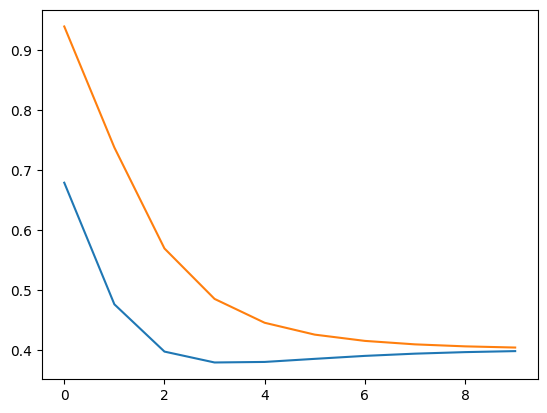

In [42]:
# Create a PsyNeuLink Composition
comp_attract = pnl.Composition()

# Create the first Transfer Mechanism with Logistic function
node_attract1 = pnl.TransferMechanism(
    name='node_attract1',  
    function=pnl.Logistic(gain=1, bias=0, offset=0),  # Logistic function with a gain of 1 and no bias and offset.
    integrator_mode=True,
    integration_rate=.5,
    default_variable=np.zeros((1,)),
)

# Create the second Transfer Mechanism with Logistic function
node_attract2 = pnl.TransferMechanism(
    name='node_attract2',
    function=pnl.Logistic(gain=1, bias=0, offset=0),  # Logistic function with a gain of 1 and no bias and offset.
    integrator_mode=True,
    integration_rate=.5,
    default_variable=np.zeros((1,)),
)

# Create the Connection Weights
connect_a1_a2 = ([-1])
connect_a2_a1 = ([-1]) 

# Create the Mapping Projections
weights_a1_a2 = pnl.MappingProjection(
    name='connect_a1_a2',
    matrix=connect_a1_a2,
)
weights_a2_a1 = pnl.MappingProjection(
    name='connect_a2_a1',
    matrix=connect_a2_a1,
)

# Add the nodes and projections to the composition
comp_attract.add_linear_processing_pathway(
    pathway=(node_attract1, weights_a1_a2, node_attract2, weights_a2_a1, node_attract1)
)

# Enable detailed reporting of output for both nodes
node_attract1.reportOutputPref = True
node_attract2.reportOutputPref = True

# Define inputs for each node over multiple trials
input_a1 = 2  # Initial input to node_attract1.
input_a2 = 6  # Initial input to node_attract2.

input_dict = {
    node_attract1: [input_a1] + [0] * 9,  # Input sequence for node_attract1.
    node_attract2: [input_a2] + [0] * 9,  # Input sequence for node_attract2.
}

# Execute the composition for a specified number of trials
comp_attract.run(
    inputs=input_dict,
    num_trials=len(input_dict[node_attract1])
)

# Plot the output
print(np.shape(np.squeeze(comp_attract.results)))
print(np.squeeze(comp_attract.results))
plt.plot(np.squeeze(comp_attract.results))

### Exercise 2

Write down the equation for activation of the node `node_attract1` with the Logistic function.

<details><summary><b>Solution</b></summary>

The activation of `node_attract1` with the Logistic function is calculated as:

with the logistic function:
$$
f(x) = \frac{1}{1 + e^{-gain * (x - bias)}} + offset
$$

the activation of `node_attract1` is:
$$
act_{1}(t) $= (1 - integration\_rate) * act_{1}(t-1) + integration\_rate * f(input_{1} - act_{2}(t-1))
$$

with gain = 1, bias = 0, and offset = 0:

$$
act_{1}(t) = (1 - integration\_rate) * act_{1}(t-1) + integration\_rate * \frac{1}{1 + e^{-(input_{1} - act_{2}(t-1))}}
$$

</details>
